<div class="alert alert-block alert-info" style="margin-top: 20px">
 <a href="http://cocl.us/pytorch_link_top"><img src = "http://cocl.us/Pytorch_top" width = 950, align = "center">

<img src = "https://ibm.box.com/shared/static/ugcqz6ohbvff804xp84y4kqnvvk3bq1g.png" width = 200, align = "center">


<h1 align=center><font size = 5>Convolutional Neral Network Simple example </font></h1> 


# Table of Contents
In this lab, we will use a Convolutional Neral Networks to classify horizontal an vertical Lines 

<div class="alert alert-block alert-info" style="margin-top: 20px">
<li><a href="#ref0">Helper functions </a></li>

<li><a href="#ref1"> Prepare Data </a></li>
<li><a href="#ref2">Convolutional Neral Network </a></li>
<li><a href="#ref3">Define Softmax , Criterion function, Optimizer and Train the  Model</a></li>
<li><a href="#ref4">Analyse Results</a></li>

<br>
<p></p>
Estimated Time Needed: <strong>25 min</strong>
</div>

<hr>

In [1]:
import time
START_TIME = time.time()

import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

In [2]:
torch.manual_seed(4)

In [3]:
print(torch.cuda.is_available())
DEV = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(DEV)

True
cuda:0


### Helper functions

Define the function *plot_channels* to plot out the kernel parameters of each channel.|

In [4]:
def plot_channels(W):
    n_out = W.shape[0] # number of output channels 
    n_in  = W.shape[1] # number of input channels
    w_min, w_max = W.min().item(), W.max().item()
    
    fig, axes = plt.subplots(n_out, n_in)
    fig.subplots_adjust(hspace=0.1)
    out_ix, in_ix = 0, 0 
    # plot outputs as rows,  inputs as columns 
    for ax in axes.flat:
        if in_ix > n_in - 1:
            out_ix += 1
            in_ix = 0
              
        ax.imshow(W[out_ix, in_ix, :, :].cpu(), vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_ix += 1

    plt.show()

<code>show_data</code>: plot out data sample

In [5]:
def show_data(dataset, sample):
    plt.imshow(dataset.x[sample, 0, :, :].numpy(),cmap='gray')
    plt.title('y=' + str(dataset.y[sample].item()))
    plt.show()

Create some toy data:

In [6]:
from torch.utils.data import Dataset, DataLoader
class Data(Dataset):
    def __init__(self, n_img=100, offset=0, p=0.9, train=False):
        """
        p: probability that pixel is white?  
        n_img: number of images 
        offset: set a random vertical and horizontal offset images by a sample, should be less than 3 
        """
        if train: np.random.seed(1)  
        
        n_img = 2 * (n_img // 2) # make images multiple of 3 
        images = np.zeros((n_img, 1, 11, 11))
        start1, start2 = 3, 1
        self.y = torch.zeros(n_img).type(torch.long)

        for n in range(n_img):
            if offset > 0:
                low = int(np.random.randint(low=start1, high=start1 + offset, size=1))
                high = int(np.random.randint(low=start2, high=start2 + offset, size=1))
            else:
                low=4
                high=1
        
            if n <= n_img//2:
                self.y[n] = 0
                images[n, 0, high:high + 9, low:low + 3] = np.random.binomial(1, p, (9, 3))
            else: # if  n > n_img//2:
                self.y[n] = 1
                images[n, 0, low:low + 3, high:high + 9] = np.random.binomial(1, p, (3, 9))
        #
        self.x  = torch.from_numpy(images).type(torch.FloatTensor)
        self.len = self.x.shape[0]
        del(images)
        np.random.seed(0)
        
    def __getitem__(self, ix):      
        return self.x[ix], self.y[ix]
      
    def __len__(self):
        return self.len

<code>plot_activation</code>: plot out the activations of the Convolutional layers  

In [7]:
def plot_activations(img, num_rows=1, name=""):
    img = img[0, :, :, :].cpu().detach().numpy() # <--- 
    num_activ = img.shape[0]
    print(num_activ)
    A_min, A_max = img.min().item(), img.max().item()
    if num_activ == 1:
        ## Plot the image.
        plt.imshow(img[0, :], vmin=A_min, vmax=A_max, cmap='seismic')
    else:
        fig, axes = plt.subplots(num_rows, num_activ // num_rows)
        fig.subplots_adjust(hspace = 0.4)
        for ix, ax in enumerate(axes.flat):
            if ix < num_activ:
                ## Set the label for the sub-plot.
                ax.set_xlabel( "activation:{0}".format(ix + 1))
                ## Plot the image.
                ax.imshow(img[ix, :], vmin=A_min, vmax=A_max, cmap='seismic')
                ax.set_xticks([])
                ax.set_yticks([])
    plt.show()


Utility function for computing output of convolutions
takes a tuple (h, w) and returns a tuple (h, w)

In [8]:
from math import floor

def conv_output_shape(h_w, kernel_size=1, stride=1, pad=0, dilation=1):
    ## by Duane Nielsen
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    #
    h = floor( ((h_w[0] + (2 * pad) - (dilation * (kernel_size[0] - 1) ) - 1 ) / stride) + 1)
    w = floor( ((h_w[1] + (2 * pad) - (dilation * (kernel_size[1] - 1) ) - 1 ) / stride) + 1)
    return h, w

### Prepare Data

Load the training dataset with 10000 samples 

In [9]:
N_images = 10000

train_dataset = Data(n_img=N_images)

Load the testing dataset

In [10]:
validation_dataset = Data(n_img=1000, train=False)
validation_dataset

we can see the data type is long 

### Data Visualization 

Each element in the rectangular  tensor corresponds to a number representing a pixel intensity  as demonstrated by  the following image.

We can print out the third label 

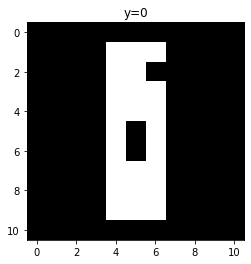

In [11]:
show_data(train_dataset, 0)

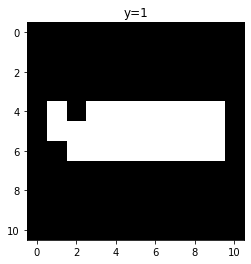

In [12]:
show_data(train_dataset, N_images//2 + 2)

We can plot the 3rd  sample 

### Build a Convolutional Neral Network Class 

The input image is 11 x11, the following will change the size of the activations:
- 1st convolutional layer
- 1st max pooling layer
- 2nd convolutional layer
- 2nd max pooling layer

With the following parameters *kernel_size*, *stride* and *pad*.  
We use the following  lines of code to change the image before we get to the *fully connected layer*.

In [13]:
out = conv_output_shape((11, 11), kernel_size=2, stride=1, pad=0, dilation=1)
print("init img, kernel_size=2, stride=1, pad=0, dilation=1 => ", out)

out1 = conv_output_shape(out, kernel_size=2, stride=1, pad=0, dilation=1)
print("\nout  img, kernel_size=2, stride=1, pad=0, dilation=1 => ", out1)

out2 = conv_output_shape(out1, kernel_size=2, stride=1, pad=0, dilation=1)
print("\nout1 img, kernel_size=2, stride=1, pad=0, dilation=1 => ", out2)

out3 = conv_output_shape(out2, kernel_size=2, stride=1, pad=0, dilation=1)
print("\nout2 img, kernel_size=2, stride=1, pad=0, dilation=1 => ", out3)

init img, kernel_size=2, stride=1, pad=0, dilation=1 =>  (10, 10)

out  img, kernel_size=2, stride=1, pad=0, dilation=1 =>  (9, 9)

out1 img, kernel_size=2, stride=1, pad=0, dilation=1 =>  (8, 8)

out2 img, kernel_size=2, stride=1, pad=0, dilation=1 =>  (7, 7)


Build a Convolutional Network class with:
- 2 Convolutional (Conv) layers and 
- 1 Fully Connected (FC) layer. 

Pre-determine the size of the final output matrix.  
The parameters in the constructor are the number of output channels for the first and second layer.

In [14]:
class CNN(nn.Module):
    def __init__(self, out_1=2, out_2=1):
        super().__init__()
        ## 1st Convolutional Layer + max pooling
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=2, padding=0)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=1)
        #
        ## 2nd Convolutional Layer + max pooling
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=2, stride=1, padding=0)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=1)
        #
        ## Fully connected layer 
        self.fc1 = nn.Linear(out_2*7*7, 2) # 49, 2 outputs
        
    def forward(self, x):
        x = self.cnn1(x)          ## 1st Convolutional layer
        x = torch.relu(x)         ## activation function 
        x = self.maxpool1(x)      ## max pooling 
        #
        x = self.cnn2(x)          ## 2nd Convolutional layer
        x = torch.relu(x)         ## activation function
        x = self.maxpool2(x)      ## max pooling
        #
        x = x.view(x.size(0), -1) ## flatten output 
        x = self.fc1(x)           ## fully connected layer
        return x
    
    def activations(self, x):
        ## outputs activation - this is not necessary just for fun 
        x = x.to(DEV) # <--- 
        z1  = self.cnn1(x)
        a1  = torch.relu(z1)
        out = self.maxpool1(a1)
        #
        z2  = self.cnn2(out)
        a2  = torch.relu(z2)
        out = self.maxpool2(a2)
        #
        out = out.view(out.size(0),-1)
        return z1, a1, z2, a2, out     

### Define the Convolutional Neural Network Classifier  
    
Mode, criterion function, Optimizer and Train the  Model.  
There are 2 output channels for the first layer, and 1 outputs channel for the second layer.  
We can see the model parameters.

In [15]:
model = CNN(2, 1)
model.to(DEV)
model

CNN(
  (cnn1): Conv2d(1, 2, kernel_size=(2, 2), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(2, 1, kernel_size=(2, 2), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=49, out_features=2, bias=True)
)

Plot the model parameters for the kernels before training the kernels.  
The kernels are initialized randomly.

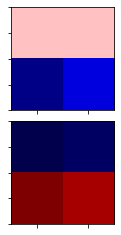

In [16]:
plot_channels(model.state_dict()['cnn1.weight'])

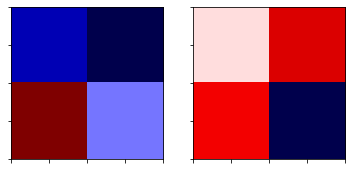

In [17]:
plot_channels(model.state_dict()['cnn2.weight'])

Define the loss function (cross entropy loss): 

In [18]:
criterion = nn.CrossEntropyLoss()

 Define learning rate and optimizer:  

In [19]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Define train and validation data (bunch): 

In [20]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=10)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=20)

Train the model and determine validation accuracy technically test accuracy **(This may take a long time)**

In [21]:
n_epochs = 10
cost_list, acc_list = [], []
n_test = len(validation_dataset)
cost = 0

start = time.time()
for epoch in range(n_epochs):
    cost = 0
    for x, y in train_loader:  
        optimizer.zero_grad()  ## clear gradient
        x, y = x.to(DEV), y.to(DEV)
        z = model(x)           ## make a prediction 
        loss = criterion(z, y) ## calculate loss 
        loss.backward()        ## calculate gradients of parameters 
        optimizer.step()       ## update parameters 
        cost += loss.item()
    cost_list.append(cost)
    #   
    correct = 0
    for x_test, y_test in validation_loader: ## perform a prediction on the validation data
        x_test, y_test = x_test.to(DEV), y_test.to(DEV)
        z = model(x_test) 
        _, yhat = torch.max(z.data, 1)
        correct += (yhat == y_test).sum().item()
    #
    acc = correct / n_test
    acc_list.append(acc)

print("elapsed time (s): ", time.time() - start)

elapsed time (s):  15.98471999168396


### Analyse Results

Plot the loss and accuracy on the validation data:

In [22]:
def plot_(cost_list, acc_list):
  # plt.figure(figsize=(10.1, 8))
  fig, ax1 = plt.subplots()
  color = 'tab:red'
  ax1.plot(cost_list, color=color)
  ax1.set_xlabel('epoch',color=color)
  ax1.set_ylabel('total loss',color=color)
  ax1.tick_params(axis='y', color=color)
  #  
  ax2 = ax1.twinx()  
  color = 'tab:blue'
  ax2.set_ylabel('accuracy', color=color)  
  ax2.plot(acc_list, color=color)
  ax2.tick_params(axis='y', labelcolor=color)
  fig.tight_layout()
  return 

<Figure size 727.2x576 with 0 Axes>

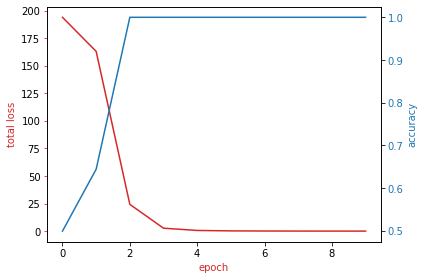

In [23]:
plot_(cost_list, acc_list)

View the results of the parameters for the Convolutional layers 

In [24]:
model.state_dict()['cnn1.weight']

tensor([[[[ 0.3660,  0.4754],
          [-0.1137, -0.1641]]],


        [[[-0.4314, -0.2817],
          [ 0.9364,  0.8696]]]], device='cuda:0')

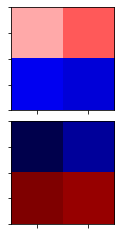

In [25]:
plot_channels(model.state_dict()['cnn1.weight'])

In [26]:
model.state_dict()['cnn1.weight']

tensor([[[[ 0.3660,  0.4754],
          [-0.1137, -0.1641]]],


        [[[-0.4314, -0.2817],
          [ 0.9364,  0.8696]]]], device='cuda:0')

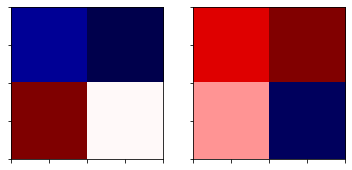

In [27]:
plot_channels(model.state_dict()['cnn2.weight'])

Consider the following sample: 

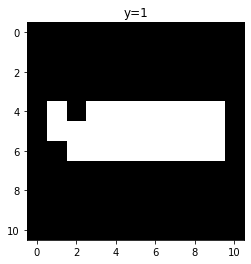

In [28]:
show_data(train_dataset, N_images // 2 + 2)

Determine the activations 

In [29]:
out = model.activations(train_dataset[N_images // 2 + 2][0].view(1, 1, 11, 11))
out = model.activations(train_dataset[0][0].view(1, 1, 11, 11))

Plot them out

2


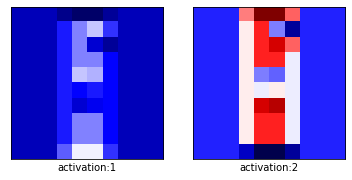

In [30]:
plot_activations(out[0], num_rows=1, name=" feature map")
plt.show()

1


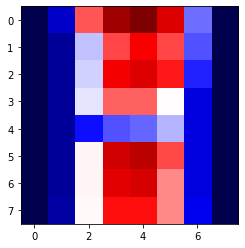

In [31]:
plot_activations(out[2], num_rows=1, name="2nd feature map")
plt.show()

1


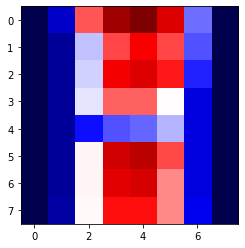

In [32]:
plot_activations(out[3], num_rows=1, name="first feature map")
plt.show()

We save the output of the activation after flattening  

In [33]:
out1 = out[4][0].cpu().detach().numpy()

We can do the same for a sample  where y=0: 

In [34]:
out0 = model.activations(train_dataset[100][0].view(1, 1, 11, 11))[4][0].cpu().detach().numpy()
out0

array([0.74465394, 1.7766035 , 2.3736956 , 2.3736956 , 2.3736956 ,
       2.0033092 , 0.97135955, 0.6001343 , 1.3013442 , 1.730864  ,
       1.730864  , 1.730864  , 1.5049968 , 0.8037873 , 0.6001343 ,
       1.3013442 , 1.730864  , 1.730864  , 1.730864  , 1.5049968 ,
       0.8037873 , 0.62997   , 1.4068213 , 1.8102767 , 1.8102767 ,
       1.7896104 , 1.5049968 , 0.8037873 , 0.62997   , 1.4068213 ,
       1.8285277 , 1.8867157 , 1.8867157 , 1.5049968 , 0.8037873 ,
       0.6788533 , 1.6384139 , 2.2526479 , 2.2526479 , 2.101019  ,
       1.5637431 , 0.8037873 , 0.77448964, 1.7917321 , 2.2526479 ,
       2.2526479 , 2.101019  , 1.5637431 , 0.8625336 ], dtype=float32)

Text(0, 0.5, 'Activation')

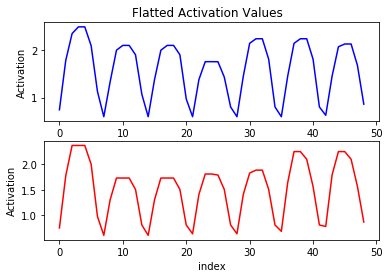

In [35]:
plt.subplot(2, 1, 1)
plt.plot( out1, 'b')
plt.title('Flatted Activation Values')
plt.ylabel('Activation')
plt.xlabel('index')
#
plt.subplot(2, 1, 2)
plt.plot(out0, 'r')
plt.xlabel('index')
plt.ylabel('Activation')

In [36]:
# Done
print("elapsed time (s): ", time.time() - START_TIME)  
# gpu:  20.151211738586426
# cpu:  29.02483892440796

elapsed time (s):  20.151211738586426


### About the Authors:  
[Joseph Santarcangelo]( https://www.linkedin.com/in/joseph-s-50398b136/) has a PhD in Electrical Engineering. His research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. 

Other contributors: [Michelle Carey](  https://www.linkedin.com/in/michelleccarey/) 

  <hr>
Copyright &copy; 2018 [cognitiveclass.ai](cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).